In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchAA import torchAA
from torchNMF import NMF
from ShiftNMF_half_frequencies import ShiftNMF
from torchShiftAA import torchShiftAA
import torch

cpu


## Data

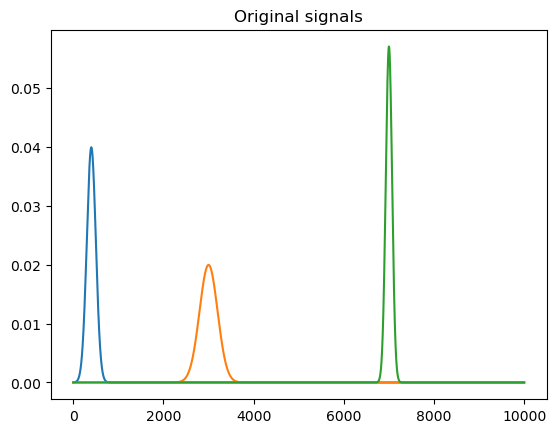

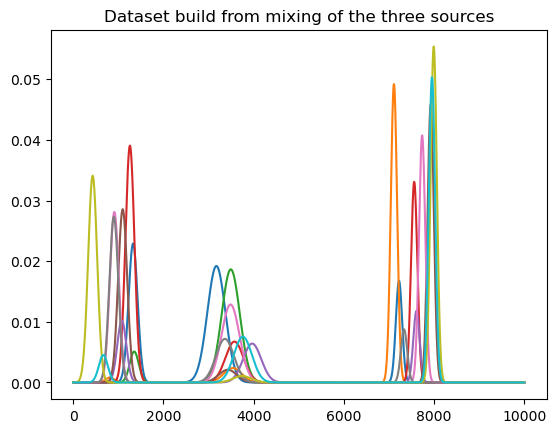

In [2]:
#Create data
# Define random sources, mixings and shifts; H, W and tau
N, M, d = 10, 10000, 3
Fs = 1000  # The sampling frequency we use for the simulation
t0 = 10    # The half-time interval we look at
t = np.arange(-t0, t0, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/len(t))  # the corresponding frequency samples

def gauss(mu, s, time):
    return 1/(s*np.sqrt(2*np.pi))*np.exp(-1/2*((time-mu)/s)**2)


def shift_dataset(W, H, tau):
    # Get half the frequencies
    Nf = H.shape[1] // 2 + 1
    # Fourier transform of S along the second dimension
    Hf = np.fft.fft(H, axis=1)
    # Keep only the first Nf[1] elements of the Fourier transform of S
    Hf = Hf[:, :Nf]
    # Construct the shifted Fourier transform of S
    Hf_reverse = np.fliplr(Hf[:, 1:Nf - 1])
    # Concatenate the original columns with the reversed columns along the second dimension
    Hft = np.concatenate((Hf, np.conj(Hf_reverse)), axis=1)
    f = np.arange(0, M) / M
    omega = np.exp(-1j * 2 * np.pi * np.einsum('Nd,M->NdM', tau, f))
    Wf = np.einsum('Nd,NdM->NdM', W, omega)
    # Broadcast Wf and H together
    Vf = np.einsum('NdM,dM->NM', Wf, Hft)
    V = np.fft.ifft(Vf)
    return V

# Random mixings:
W = np.random.rand(N, d)
# Random gaussian shifts
tau = np.random.randint(0, 1000, size=(N, d))
#tau = np.random.randint(0, 1000, size=(N, d))
# Purely positive underlying signals. I define them as 3 gaussian peaks with random mean and std.
mean = [40, 300, 700]
std = [10, 20, 7]
t = np.arange(0, 1000, 0.1)
H = np.array([gauss(m, s, t) for m, s in list(zip(mean, std))])
plt.figure()
for signal in H:
    plt.plot(signal)
plt.title("Original signals")
plt.show()

X = shift_dataset(W, H, tau)


plt.figure()
for signal in X:
    plt.plot(signal.real)
plt.title("Dataset build from mixing of the three sources")
plt.show()

## Regular NMF

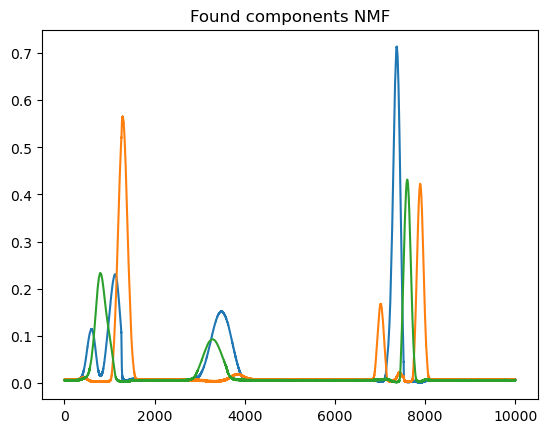

c:\Users\Lenovo\miniconda3\envs\fp\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


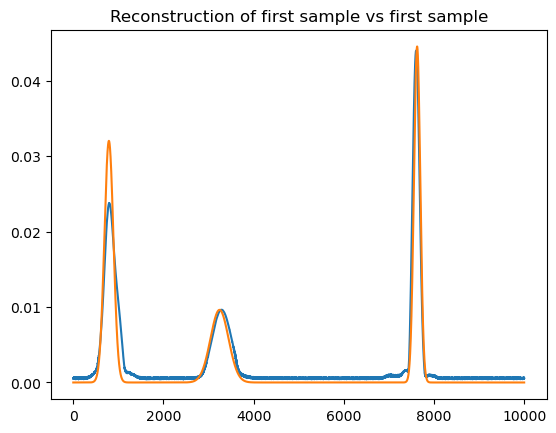

In [3]:

nmf = NMF(X, 3)
W, H = nmf.fit(verbose=True)
recon = np.matmul(W, H)

for signal in H:
    plt.plot(signal)
plt.title("Found components NMF")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

## Shift NMF

In [3]:

nmf = ShiftNMF(X, 3)
W, H, tau = nmf.fit(verbose=True)
recon = nmf.recon.detach().numpy()

for signal in H:
    plt.plot(signal)
plt.title("Found components shift NMF")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau")
plt.show()

ValueError: Complex data not supported
[[-2.11031193e-15-2.77627947e-16j -2.11457518e-15-2.58700633e-16j
  -2.11599627e-15-2.38080598e-16j ... -2.10249596e-15-3.39253641e-16j
  -2.10604867e-15-3.23216567e-16j -2.10533813e-15-3.02163911e-16j]
 [-2.52597943e-16-4.72340171e-16j -2.54463117e-16-4.70971039e-16j
  -2.61923816e-16-4.70777450e-16j ... -2.40873987e-16-4.72341920e-16j
  -2.45137244e-16-4.71802223e-16j -2.49045229e-16-4.72510835e-16j]
 [ 1.08388853e-15+2.41732847e-16j  1.09396936e-15+2.43141174e-16j
   1.10724763e-15+2.42120707e-16j ...  1.04996012e-15+2.40152601e-16j
   1.06128439e-15+2.40588146e-16j  1.07105436e-15+2.41888838e-16j]
 ...
 [-1.95399252e-16+5.45343342e-16j -1.88338234e-16+5.48671651e-16j
  -1.83320026e-16+5.54657780e-16j ... -2.10764739e-16+5.31811073e-16j
  -2.04847250e-16+5.36213801e-16j -1.99795736e-16+5.39085428e-16j]
 [-1.94977368e-16-4.22145834e-16j -1.94289029e-16-4.14901307e-16j
  -1.96065386e-16-4.06414193e-16j ... -1.84199547e-16-4.46645439e-16j
  -1.87723112e-16-4.39192918e-16j -1.89973650e-16-4.31098302e-16j]
 [ 3.58690855e-16+6.60320325e-16j  3.70148356e-16+6.59205410e-16j
   3.73412412e-16+6.59754987e-16j ...  3.39105827e-16+6.59649372e-16j
   3.41342926e-16+6.60169423e-16j  3.52176621e-16+6.61438754e-16j]]


## Regular AA

c:\Users\Lenovo\OneDrive\Skrivebord\Fagprojekt\02466Fagprojekt2023\torchAA.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.C = torch.tensor(self.C, requires_grad=True)
c:\Users\Lenovo\OneDrive\Skrivebord\Fagprojekt\02466Fagprojekt2023\torchAA.py:40: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:276.)
  CX = torch.matmul(self.softmax(self.C).double(), self.X.double())


c:\Users\Lenovo\miniconda3\envs\fp\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


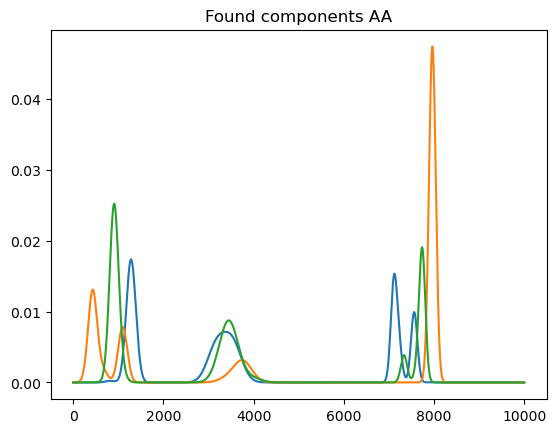

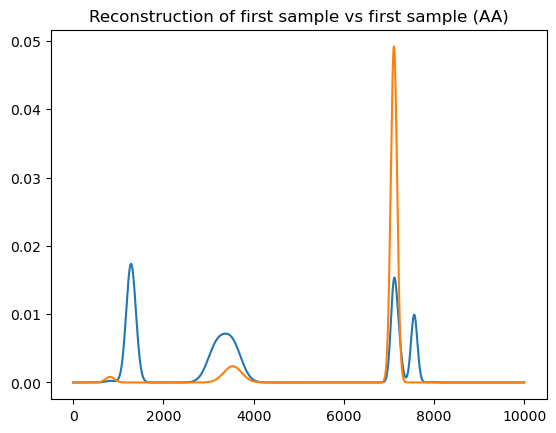

In [3]:
AA = torchAA(X, 3)
C, S = AA.fit(verbose=True)
CX = np.matmul(C, X)
recon = np.matmul(S, CX)

for signal in CX:
    plt.plot(signal)
plt.title("Found components AA")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample (AA)")
plt.show()

## Shift AA

epoch: 1, Loss: 1.1307658449437252
epoch: 2, Loss: 1.1469271758037065
epoch: 3, Loss: 1.0911190294490354
epoch: 4, Loss: 1.0266572859725327
epoch: 5, Loss: 0.9511029750559722
epoch: 6, Loss: 0.8733741642530227
epoch: 7, Loss: 0.803257484630564
epoch: 8, Loss: 0.7513266612832944
epoch: 9, Loss: 0.7208746364972918
epoch: 10, Loss: 0.7025414660502419
epoch: 11, Loss: 0.6891618052128216
epoch: 12, Loss: 0.6754136618044795
epoch: 13, Loss: 0.6577862781655609
epoch: 14, Loss: 0.639676700202126
epoch: 15, Loss: 0.6254700596227147
epoch: 16, Loss: 0.617728517102097
epoch: 17, Loss: 0.6136417775015133
epoch: 18, Loss: 0.6102158264356702
epoch: 19, Loss: 0.6080065975010802
epoch: 20, Loss: 0.6077280105847541


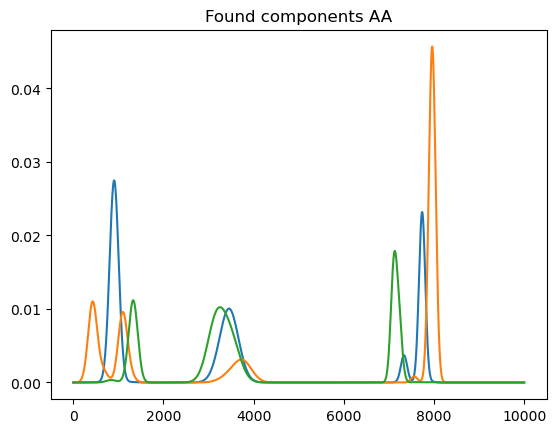

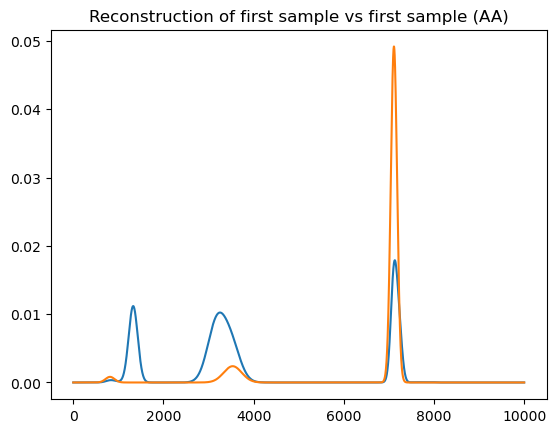

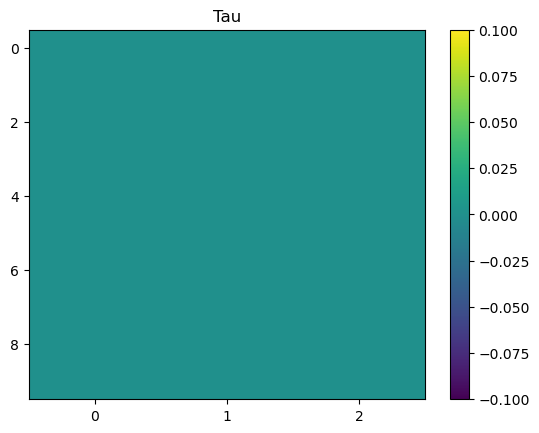

In [4]:
AA = torchShiftAA(X, 3)
C, S, tau = AA.fit(verbose=True)

recon = AA.recon.detach().resolve_conj().numpy()
A = torch.fft.ifft(AA.A_F).detach().numpy()

CX = A
SCX = recon

for signal in CX:
    plt.plot(signal)
plt.title("Found components AA")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample (AA)")
plt.show()

plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau")
plt.show()